# Design variables

Design variables are the principal element within an optimization problem. During the optimization, the design variables are changed while influencing the objective function.

These variables can be either continuous or discrete depending on the type of optimization problem that is being studied. The turbine positions are the most common continuous design variable used in wind farm layout optimization. In essence, they are continuous because they can take an infinite amount of values for a given range. Discrete variables, on the other hand, can only take finite amount of values for a specific interval. A common discrete variable used in wind farm optimization is turbine type. The type of design variable will influence the decision of the optimization driver to use.

Continuous design variables can be treated with both gradient-free and gradient-based algorithms, where the calculation of the derivatives (in gradient-based cases) can be performed. On the other hand, discrete variables are usually analyzed with gradient-free methods, as the calculation of the gradients of these variables is not possible to perform. In some cases, it is possible to convert the discrete variable into a continuous one and then find its derivative.

Besides the turbine positions, the development of TOPFARM has allowed the inclusion of several other design variables such as:

- Turbine types,
- Turbine hub heights,
- Yaw angles,
- and even the inter-turbine spacing and rotation of a wind farm seen as a grid.

This example goes through two of the most common design variables available in TOPFARM and describes how to set them up within the `TopFarmProblem` object in the optimization.

Before working on the notebook exercises, make sure that you import or install topfarm on your newly created environment.
Ensure you are using Python 3.8 or 3.9 for compatibility with pyDOE2 and OpenMDAO.

In [2]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [3]:
import subprocess
import sys
import pandas as pd
import numpy as np

# check if a package is installed
def check_and_install(package):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of packages to check and install
packages = ["openmdao[doe]", "pyDOE2"]

for pkg in packages:
    check_and_install(pkg)

openmdao[doe] is not installed. Installing...
pyDOE2 is not installed. Installing...


**First we import some supporting Python libraries**

In [4]:
import matplotlib.pyplot as plt

**We start by importing the turbine and site to use as well as the wake model from PyWake.**

**From TOPFARM we import**:

- **TopFarmProblem**. Overall topfarm problem class to which the objectives, design variables, and constraints are added
- **EasyScipyOptimizeDriver**. A subclass of ScipyOptimizeDriver which is configured for the given workflow
- **get_iea37_initial, get_iea37_constraints, get_iea37_cost**. Functions to get the initial layout, the constraints and the cost function for the IEA task 37 benchmark example
- **NoPlot, XYPlotComp**. Plotting components to visualize the results

In [5]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian     #wake model
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site         #wind turbines and site used
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent   #cost model

from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost
from topfarm.plotting import NoPlot, XYPlotComp
import sys
import os
import xarray as xr

# Add the directory containing Master_meteo to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

#from Master_meteo.ipynb import wp0, wp1

In [7]:
wp0 = xr.open_dataset("C:\\Users\\annem\\OneDrive - Danmarks Tekniske Universitet\\General\\Testing_materials\\Data_Share\\condense_WP0.nc")
wp1 = xr.open_dataset("C:\\Users\\annem\\OneDrive - Danmarks Tekniske Universitet\\General\\Testing_materials\\Data_Share\\condense_WP1.nc")

# Extract wind speed and wind direction from wp0
ws = wp0.WS.isel(time=0, height=3)  # Select wind speed at 150m height, for the first time step
wd = wp0.WD.isel(time=0, height=3)  # Select wind direction at 150m height, for the first time step

# Convert wind direction (WD) from degrees to radians
wd_rad = np.deg2rad(wd)

# Convert wind speed and direction to u and v components (east-west and north-south components)
u = -ws * np.sin(wd_rad)  # u-component (east-west)
v = -ws * np.cos(wd_rad)  # v-component (north-south)

mean_u = np.mean(u)  # Mean u-component
mean_v = np.mean(v)  # Mean v-component

# take average and add perturbations, take into account the wind direction circularity
mean_ws = np.mean(ws)
meanwd_rad = np.arctan2(mean_u, mean_v)  # Mean wind direction in radians
mean_wd = np.rad2deg(meanwd_rad)  # Convert back to degrees
mean_wd = (mean_wd + 360) % 360  # Ensure wind direction is between 0 and 360 degrees

perturbation_factor_ws = 0.5
perturbation_factor_wd = 5  # Change this factor to control the range of perturbation
#mean_ws_perturbed = mean_ws + np.random.normal(scale=perturbation_factor)
#ws_array = np.array([mean_ws_perturbed])
#mean_ws_perturbed = mean_ws_center + np.random.normal(scale=perturbation_factor)  # Perturb the mean



class CustomSite:
    def __init__(self, wind_speed, wind_direction, site_parameters=None):
        self.wind_speed = wind_speed
        self.wind_direction = wind_direction
        # You can add other site parameters, e.g., turbine layout, geographical information
        self.site_parameters = site_parameters
    
    def get_wind_conditions(self):
        return self.wind_speed, self.wind_direction

    # Add additional methods to simulate power production, optimization, etc.
    def simulate_power(self):
        # Here, you can use the wind conditions and simulate power
        pass
# Assuming the base class is IEA37Site, subclass it for your custom site
from py_wake.examples.data.iea37 import IEA37Site  # Import the base class from the py_wake library

class CustomSite(IEA37Site):
    def __init__(self, site_id, wind_speed, wind_direction, **kwargs):
        # Initialize the parent class
        super().__init__(site_id, **kwargs)  # Call the parent constructor with necessary parameters
        
        # Store custom wind data
        self.wind_speed = wind_speed
        self.wind_direction = wind_direction

    def get_wind_conditions(self):
        # Return custom wind data (wind speed and direction)
        return self.wind_speed, self.wind_direction


## 1) Turbine position (x,y) layout optimization

First we set up the parameters for the wind farm model simulation, that is the site and wind turbine objects as well as the wind directions to study.

In [18]:
# Load the data from the Excel file
file_path = 'C:\\Users\\annem\\OneDrive - Stokman IT\\EWEM\\DTU2024-2025\\thesis\\efficiency of very large wind farms\\test_block2_MS.csv'
file = pd.read_csv(file_path)
initial_layout = file[['x', 'y']].values

n_wt = len(initial_layout[:, 0])
n_wd = 16
n_ws = 16
print(n_wt)
#site = IEA37Site(9) #why 9
# Create the custom site object with your wind conditions
# Assuming 'IEA37Site' requires an integer 'site_id' and wind conditions
site = CustomSite(site_id=9, wind_speed=mean_ws, wind_direction=mean_wd)  # Create CustomSite instance

#wind_turbines = IEA37_WindTurbines()
wind_turbines = IEA37_WindTurbines()

# Generate wind directions using np.linspace
wd = np.linspace(0., 360., n_wd, endpoint=False)

# Create the wind farm model
wfmodel = IEA37SimpleBastankhahGaussian(site, wind_turbines)  # PyWake's wind farm model
"""
# Apply unique perturbations to each wind speed and direction
wd_perturbed = mean_wd + np.random.normal(scale=perturbation_factor_wd, size=n_wd)
ws_perturbed = mean_ws + np.random.normal(scale=perturbation_factor_ws, size=n_wd)

print('wd_perturbed:', wd_perturbed)
# Clip to ensure wind speeds stay within valid range (3 m/s to 25 m/s)
ws_perturbed = np.clip(ws_perturbed, 3, 25)
# Clip to ensure wind directions stay within valid range (0° to 360°)
wd_perturbed = np.clip(wd_perturbed, 0, 360)
"""

# Correct 1D perturbed wind speeds and directions as xarray.DataArray
ws_perturbed = xr.DataArray(
    np.clip(mean_ws + np.random.normal(scale=perturbation_factor_ws, size=n_ws), 3, 25),
    dims="ws"
)

wd_perturbed = xr.DataArray(
    (mean_wd + np.random.normal(scale=perturbation_factor_wd, size=n_wd)) % 360,
    dims="wd"
)

print('Perturbed mean wind speed:', ws_perturbed)
print('Perturbed mean wind direction:', wd_perturbed)
# Use the data from the file for initial layout

# plot initial layout
plt.figure()
plt.plot(initial_layout[:, 0], initial_layout[:, 1], 'o')
plt.title('Initial layout')
plt.axis('equal')
plt.show()


#n_wt = 9
#n_wd = 16

#site = IEA37Site(9)
#wind_turbines = IEA37_WindTurbines()
#wd = np.linspace(0.,360.,n_wd, endpoint=False)
#wfmodel = IEA37SimpleBastankhahGaussian(site, wind_turbines)   #PyWake's wind farm model

# use excel file to get initial layout
#file_path = r'C:\Users\annem\OneDrive - Stokman IT\EWEM\DTU2024-2025\thesis\efficiency of very large wind farms\test_block2_MS.csv'
#file = pd.read_csv(file_path)


68


c:\Users\annem\miniconda3\envs\thesis\Lib\site-packages\py_wake\deficit_models\gaussian.py:277: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


ValueError: dimensions () must have the same length as the number of data dimensions, ndim=1

60


c:\Users\annem\miniconda3\envs\thesis\Lib\site-packages\py_wake\deficit_models\gaussian.py:277: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


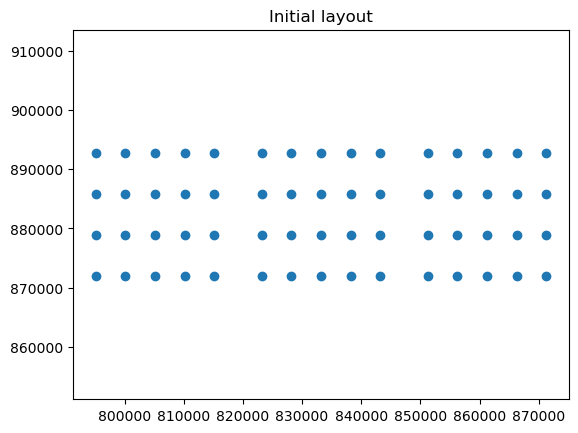

In [ ]:
# Load the data from the Excel file
file_path = 'C:\\Users\\annem\\OneDrive - Stokman IT\\EWEM\\DTU2024-2025\\thesis\\efficiency of very large wind farms\\turbine_coordinates_rectangles.csv'
file = pd.read_csv(file_path)
initial_layout = file[['X', 'Y']].values

n_wt = len(initial_layout[:, 0])
n_wd = 16
print(n_wt)
site = IEA37Site(9) #why 9
#site = CustomSite(site_id=9, wind_speed=mean_ws, wind_direction=mean_wd)

wind_turbines = IEA37_WindTurbines()
#wd = np.linspace(0., 360., n_wd, endpoint=False)
# use wd from wp0

wfmodel = IEA37SimpleBastankhahGaussian(site, wind_turbines)  # PyWake's wind farm model

# Use the data from the file for initial layout

# plot initial layout
plt.figure()
plt.plot(initial_layout[:, 0], initial_layout[:, 1], 'o')
plt.title('Initial layout')
plt.axis('equal')
plt.show()



Now we set up the `CostModelComponent` that will calculate the AEP as the objective function of the optimization.

In [ ]:
cost_comp = PyWakeAEPCostModelComponent(wfmodel, n_wt, wd=mean_wd)


Then we can set up the optimization problem, where the initial conditions of the optimization, design variables and constraints are specified.

In [ ]:
initial = get_iea37_initial(9)
driver = EasyScipyOptimizeDriver()

When using the turbine positions as design variables, you can specify them in TOPFARM in 4 different ways:

    - {'x': [1, 2, 3], 'y':([3, 2, 1], 0, 1), 'z':([4, 5, 6],[4, 5, 4], [6, 7, 6])}
    - [('x', [1,2,3]), ('y',([3,2,1], 0, 1)), ('z',([4, 5, 6],[4, 5, 4], [6, 7, 6]))]
    - [('x', ([1,2,3], 0, 3, 'm')), ('y', ([3,2,1], 'm')), ('z', ([4,5,6], [4,5,4], [6,7,6]))]
    - zip('xy', pos.T)

The values are either:

- the initial value or
- on of the following tuples:
  - initial value, unit
  - initial value, lower bound, upper bound
  - initial value, lower bound, upper bound, unit

In [ ]:
design_vars = {'x': initial_layout[:n_wt, 0], 'y': initial_layout[:n_wt, 1]}

tf_problem = TopFarmProblem(
            design_vars,
            cost_comp,
            constraints=None,
            driver=driver,
            plot_comp=XYPlotComp())

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000578 sec).
INFO: checking system...
INFO:     system check complete (0.000030 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.001769 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000042 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000426 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000826 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000048 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000011 sec).


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000198 sec).
INFO: checking system...
INFO:     system check complete (0.000027 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000151 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000041 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000005 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000176 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000048 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000008 sec).


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


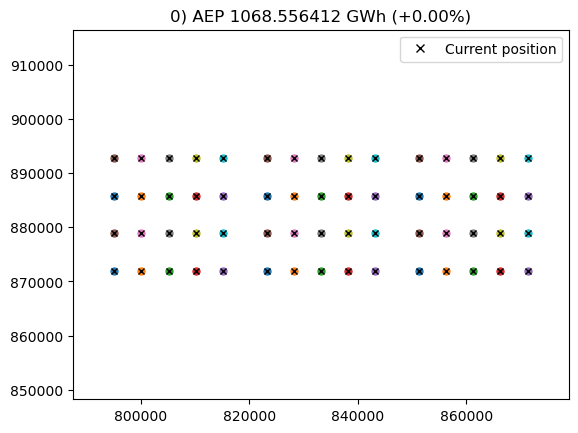

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Iteration limit reached    (Exit mode 9)
            Current function value: -1070.197539514068
            Iterations: 200
            Function evaluations: 200
            Gradient evaluations: 200
Optimization FAILED.
Iteration limit reached
-----------------------------------


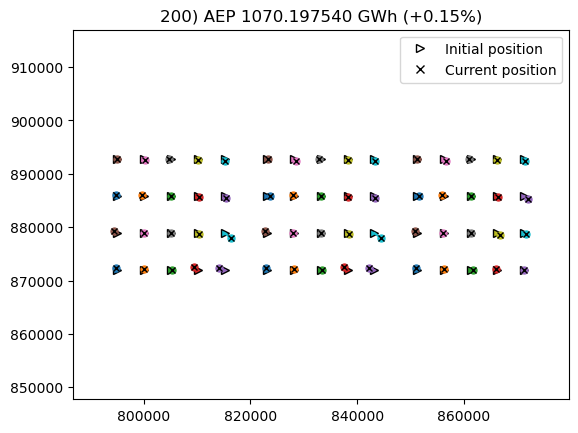

In [ ]:
_, state, _ = tf_problem.optimize()


## 2) Turbine type optimization

In this example we use the turbine types as design variables, which represent discrete points in the optimization. Because of this, gradient-based methods are not suitable and gradient-free options are needed instead. For this case, we use the **FullFactorialGenerator** as our driver (see the [Drivers](#drivers.ipnyb) tutorial for more information.) We also use the `TurbineTypePlotComponent` available in TOPFARM to visualize the final turbine types.

In [ ]:
from topfarm.cost_models.dummy import DummyCost
from topfarm._topfarm import TopFarmProblem
from openmdao.drivers.doe_generators import FullFactorialGenerator
from topfarm.plotting import TurbineTypePlotComponent, NoPlot

In [ ]:
# define the conditions for the wind farm
positions = np.array([[0, 0], [6, 6]])  # initial turbine position
optimal_types = np.array([[2], [6]])    # optimal layout

#set up plotting component for turbine types
plot_comp = TurbineTypePlotComponent(
                turbine_type_names=["Turbine %d" % i for i in range(5)],
                plot_initial=False,
                delay=0.1, legendloc=0)

In [ ]:
tf = TopFarmProblem(
            design_vars={'type': ([0, 0], 0, 4)},
            cost_comp=DummyCost(optimal_types, ['type']),
            plot_comp=plot_comp,
            driver=FullFactorialGenerator(5),
            ext_vars={'x': positions[:, 0], 'y': positions[:, 1]},
        )

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000291 sec).
INFO: checking system...
INFO:     system check complete (0.000026 sec).


INFO: checking solvers...
INFO:     solvers check complete (0.000126 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000042 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000010 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000162 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000031 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000009 sec).


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000211 sec).
INFO: checking system...
INFO:     system check complete (0.000024 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000142 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000044 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000007 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000171 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000037 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000007 sec).


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


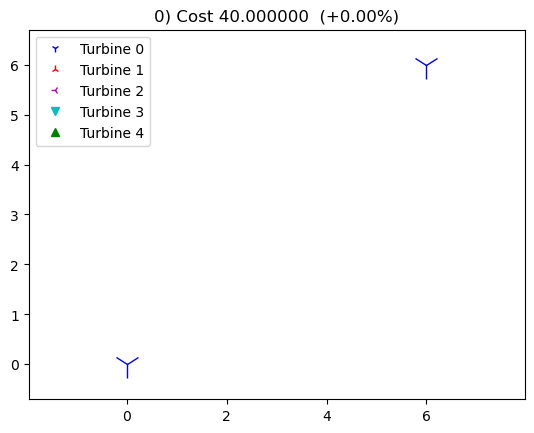

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000151 sec).
INFO: checking system...
INFO:     system check complete (0.000032 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000127 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000046 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000008 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000186 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000052 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000007 sec).


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


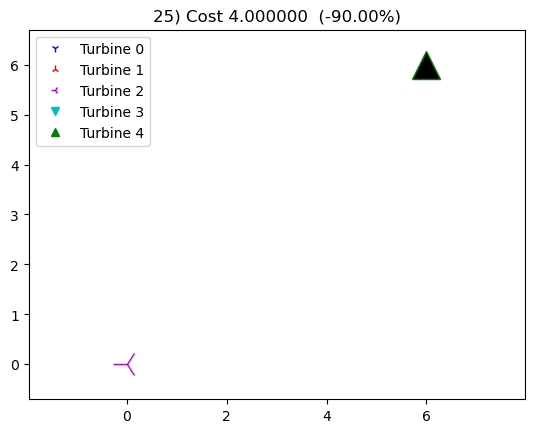

In [ ]:
state = {}
cost, state, recorder = tf.optimize(state)

In [ ]:
print(state['type'])

[2. 4.]
